In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
import theano

In [12]:
components = pd.read_csv('pd_data/components_summary_men.csv')

In [22]:
COMP_TYPES = ('ss', 'tr', 'pe', 'co', 'in')

In [13]:
skaters = sorted(components.skater.unique())
num_skaters = len(skaters)
skater_lookup = dict(zip(skaters, xrange(len(skaters))))

In [38]:
pooled_traces = {}
pooled_models = {}
unpooled_traces = {}
unpooled_models = {}
unpooled_skater_shared = {}

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 695.43it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:11<00:00, 84.28it/s]


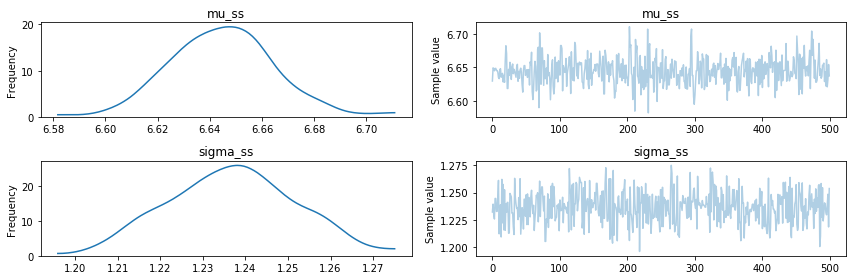

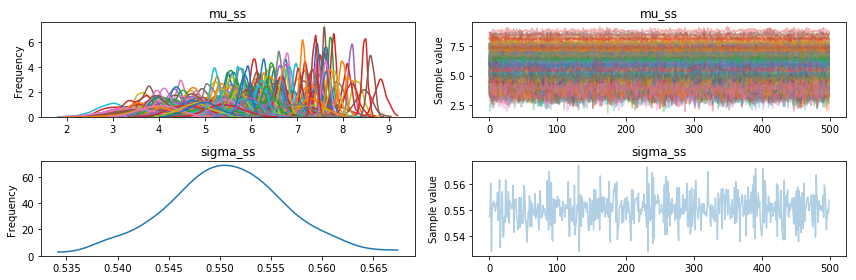

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1176.76it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:25<00:00, 38.80it/s]


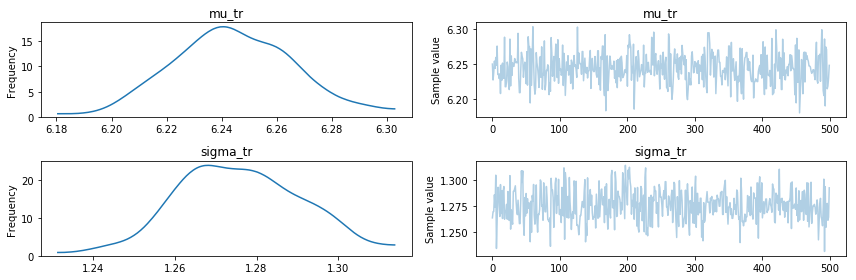

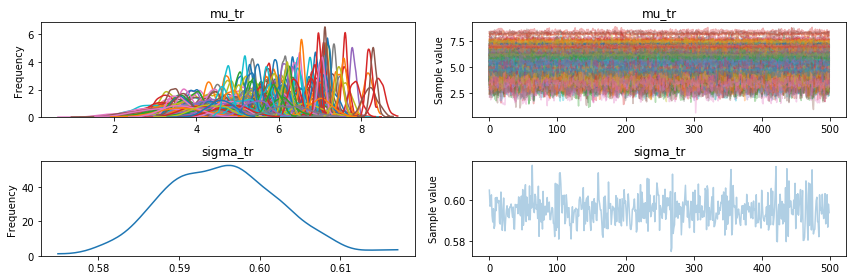

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1060.71it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:10<00:00, 97.38it/s]


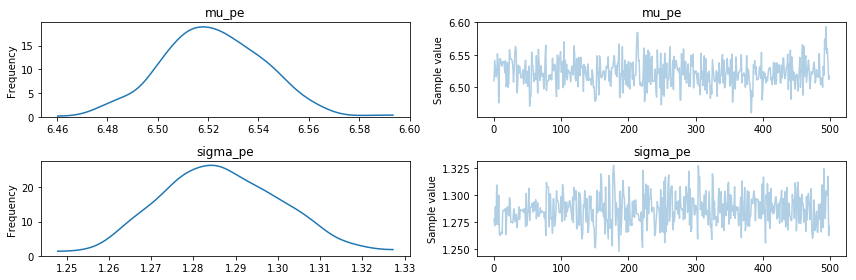

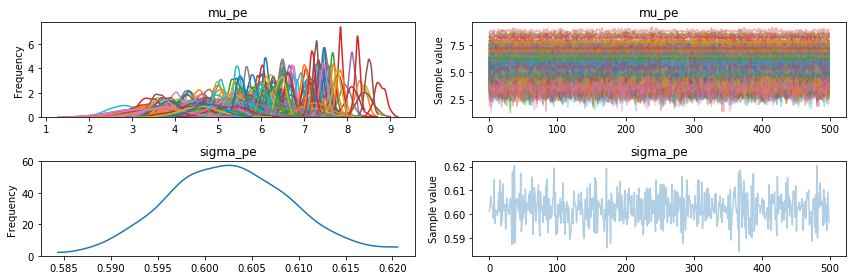

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 985.11it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:19<00:00, 51.16it/s]


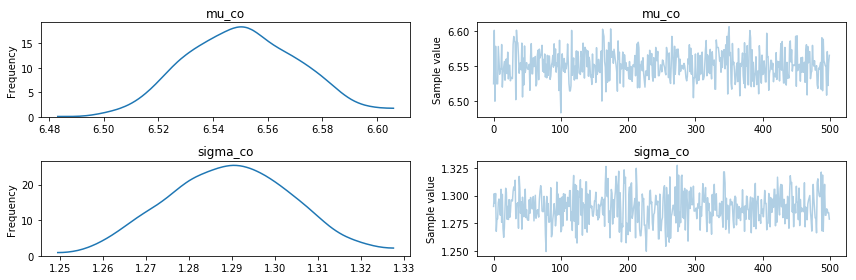

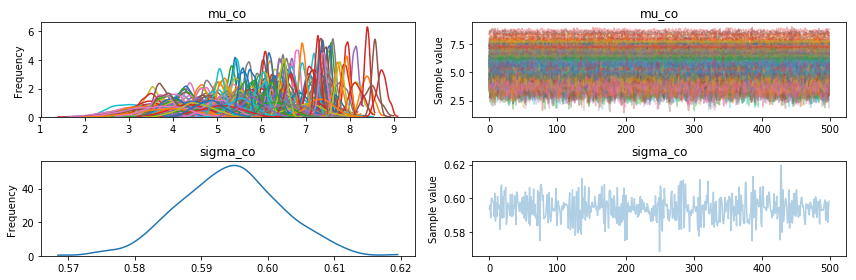

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 680.59it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:11<00:00, 88.16it/s]


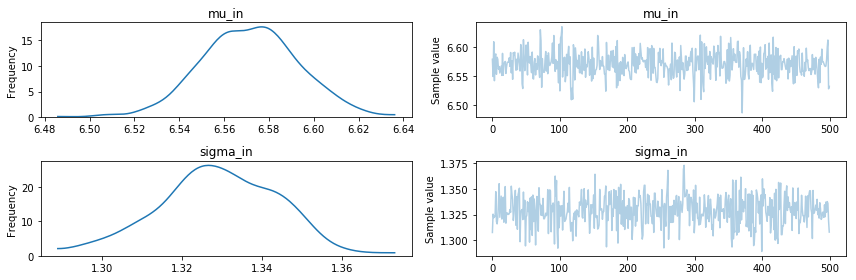

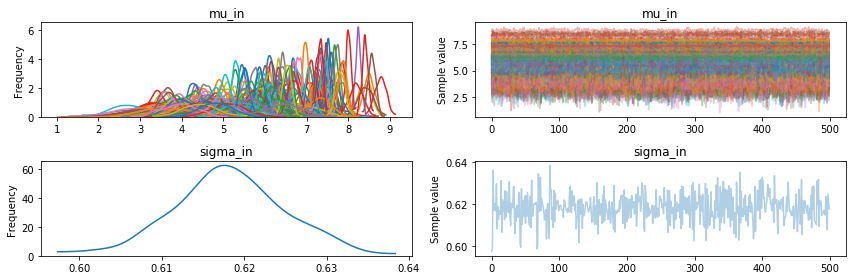

In [39]:
for comp_type in COMP_TYPES:
    comps = components[components.comp_type == comp_type]
    skater = comps['skater_code'] = comps.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    unpooled_skater_shared[comp_type] = skater
    points = comps.points

    pooled_model = pm.Model()
    with pooled_model:
        mu = pm.Normal('mu_' + comp_type, 7.0, sd=1e5)
        sigma = pm.HalfCauchy('sigma_' + comp_type, 5)
        y = pm.Normal('y_' + comp_type, mu, sd=sigma, observed=points)
        pooled_trace = pm.sample()

    pm.traceplot(pooled_trace)
    pooled_traces[comp_type] = pooled_trace
    pooled_models[comp_type] = pooled_model
    
    unpooled_model = pm.Model()

    with unpooled_model:
        mu = pm.Normal('mu_' + comp_type, 7.0, sd=1e5, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + comp_type, 5)
        y = pm.Normal('y_' + comp_type, mu[skater], sd=sigma, observed=points)
        unpooled_trace = pm.sample()

    pm.traceplot(unpooled_trace)
    unpooled_traces[comp_type] = unpooled_trace
    unpooled_models[comp_type] = unpooled_model
    plt.show()

In [41]:
with open('fits/men_nonmulti_comps.pickle', 'w') as f:
    pickle.dump((pooled_traces, pooled_models, unpooled_traces, unpooled_models, unpooled_skater_shared), f)

In [23]:
components18 = pd.read_csv('pd_data/components_summary18_men.csv')

In [40]:
unpooled_traces['co']['mu_ss']

KeyError: 'Unknown variable mu_ss'

In [43]:
def get_skater_idx(row):
    if row.skater not in skater_lookup:
        if row.comp_type == 'ss':
            return skater_lookup['Jamal OTHMAN']
        elif row.comp_type == 'co':
            return skater_lookup['Karel ZELENKA']
        elif row.comp_type == 'in':
            return skater_lookup['Igor REZNICHENKO']
        elif row.comp_type == 'tr':
            return skater_lookup['Sondre ODDVOLL BOE']
        elif row.comp_type == 'pe':
            return skater_lookup['Abzal RAKIMGALIEV']
        else:
            print 'sigh'
    return skater_lookup[row.skater]

In [44]:
components18['skater_code'] = components18.apply(get_skater_idx, axis=1)

In [42]:
for comp_type, trace in unpooled_traces.iteritems():
    print comp_type
    estimates = pd.Series(trace['mu_' + comp_type].mean(axis=0), index=skaters)
    order = estimates.sort_values().index
    print order[len(order)/2]

ss
Jamal OTHMAN
co
Karel ZELENKA
in
Igor REZNICHENKO
tr
Sondre ODDVOLL BOE
pe
Abzal RAKIMGALIEV


In [46]:
# Make predicitons.
ppc_pooled = {}
ppc_unpooled = {}
for comp_type in COMP_TYPES:
    with pooled_models[comp_type] as m:
        ppc_pooled[comp_type] = pm.sample_ppc(pooled_traces[comp_type],
                                              model=m, samples=500)['y_' + comp_type]
    with unpooled_models[comp_type] as m:
        unpooled_skater_shared[comp_type].set_value(
            np.asarray(components18[components18.comp_type == comp_type].skater_code))
        ppc_unpooled[comp_type] = pm.sample_ppc(unpooled_traces[comp_type],
                                               model=m, samples=500)['y_' + comp_type]

100%|██████████| 500/500 [00:00<00:00, 950.68it/s]


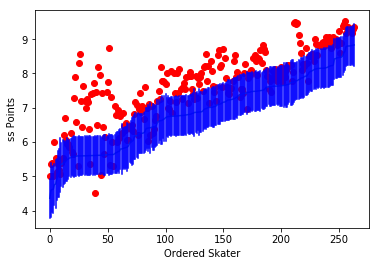

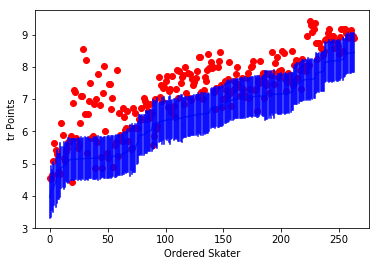

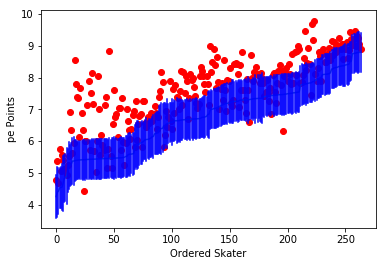

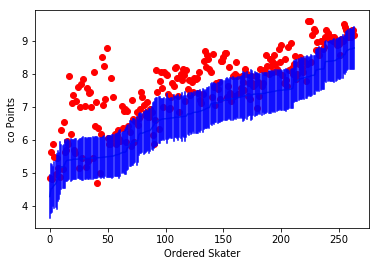

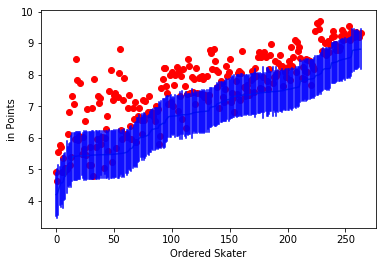

In [55]:
means = {}
for comp_type in COMP_TYPES:
    mean = ppc_unpooled[comp_type].mean(axis=0)
    means[comp_type] = mean
    std = np.std(ppc_unpooled[comp_type], axis=0)
    comp18type = components18[components18.comp_type == comp_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(comp18type.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(comp_type + ' Points');plt.xlabel('Ordered Skater');
    plt.show()

In [56]:
indices = {comp_type: 0 for comp_type in COMP_TYPES}
predictions_col = []
for index, row in components18.iterrows():
    predictions_col.append(means[row.comp_type][indices[row.comp_type]])
    indices[row.comp_type] += 1

In [64]:
components18['pooled_predictions'] = components18.apply(lambda row: pooled_traces[row.comp_type]['mu_' + row.comp_type].mean(), axis=1)

In [50]:
def plot_trace(trace, comp_type):
    estimates = pd.Series(trace['mu_' + comp_type].mean(axis=0), index=skaters)
    se = pd.Series(trace['mu_' + comp_type].std(axis=0), index=skaters)

    order = estimates.sort_values().index
    plt.scatter(range(len(estimates)), estimates[order])
    for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(comp_type + ' Points');plt.xlabel('Ordered Skater');

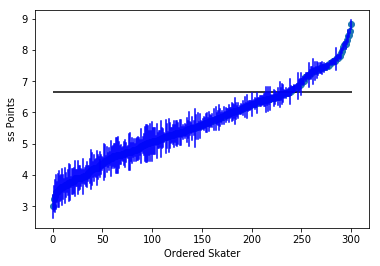

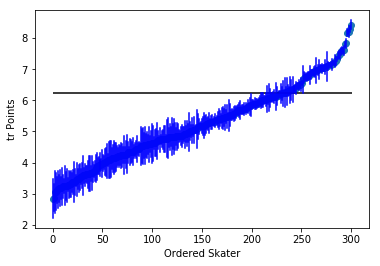

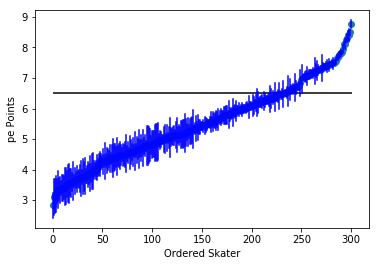

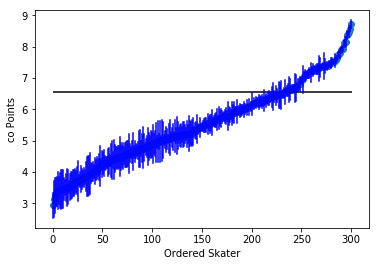

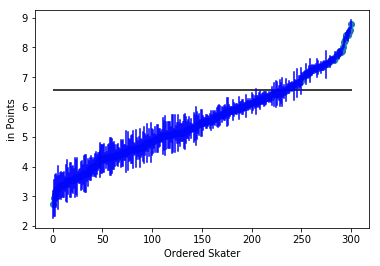

In [54]:
for comp_type in COMP_TYPES:
    plt.hlines(pooled_traces[comp_type]['mu_' + comp_type].mean(axis=0), xmin=0, xmax=301)
    plot_trace(unpooled_traces[comp_type], comp_type)
    plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:13<00:00, 75.02it/s]


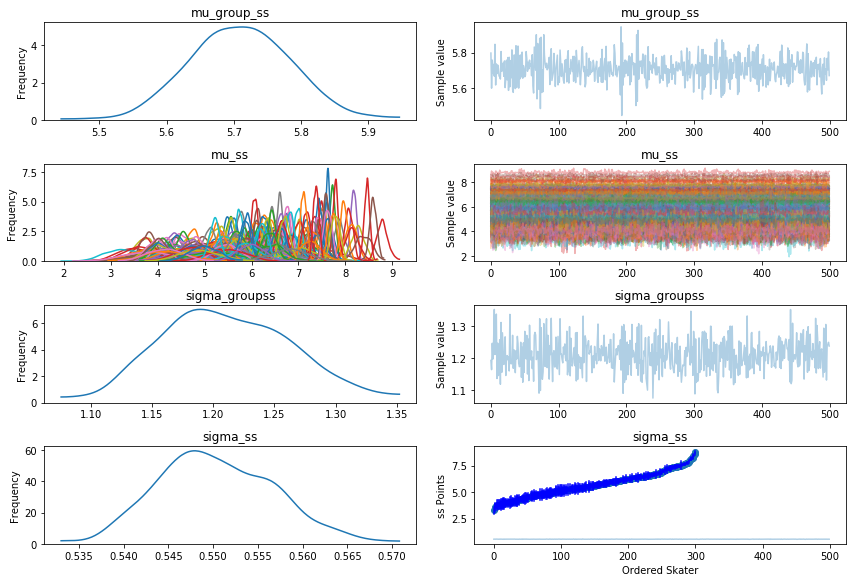

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [01:31<00:00, 10.94it/s]


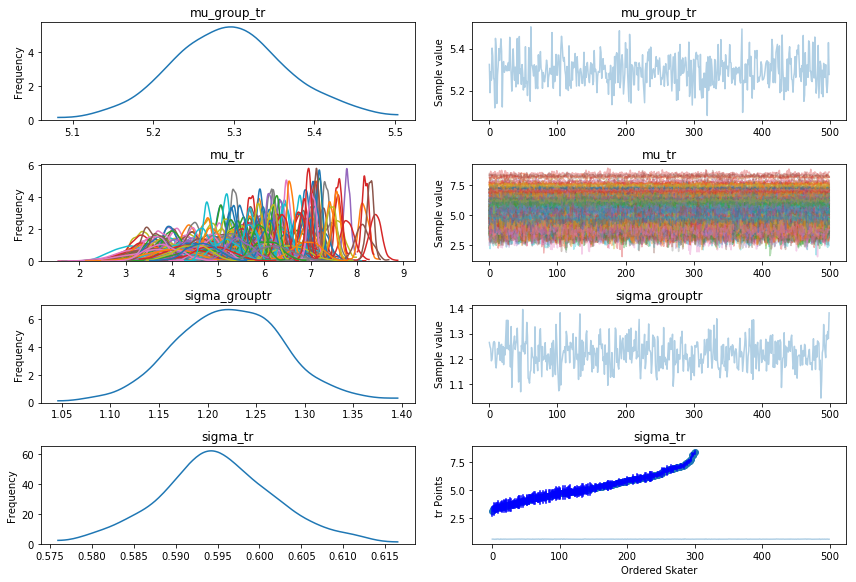

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:12<00:00, 81.64it/s]


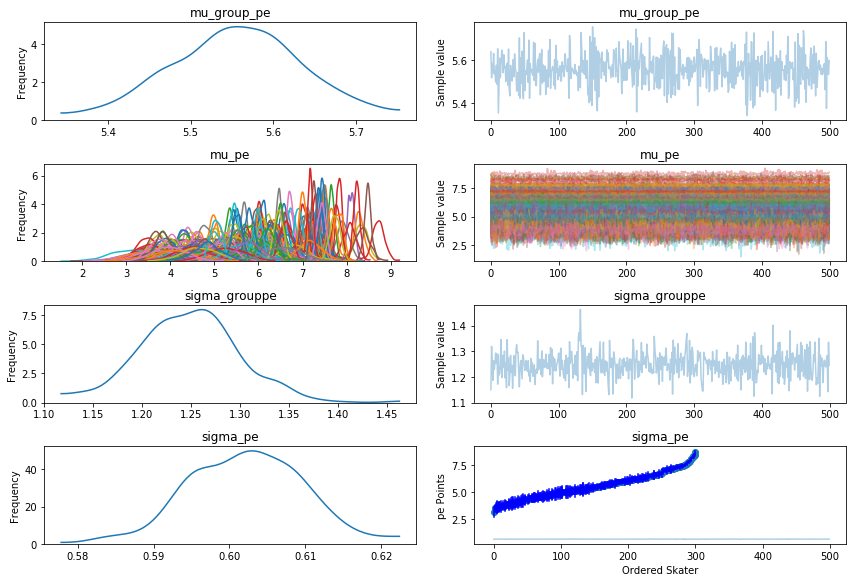

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:09<00:00, 101.85it/s]


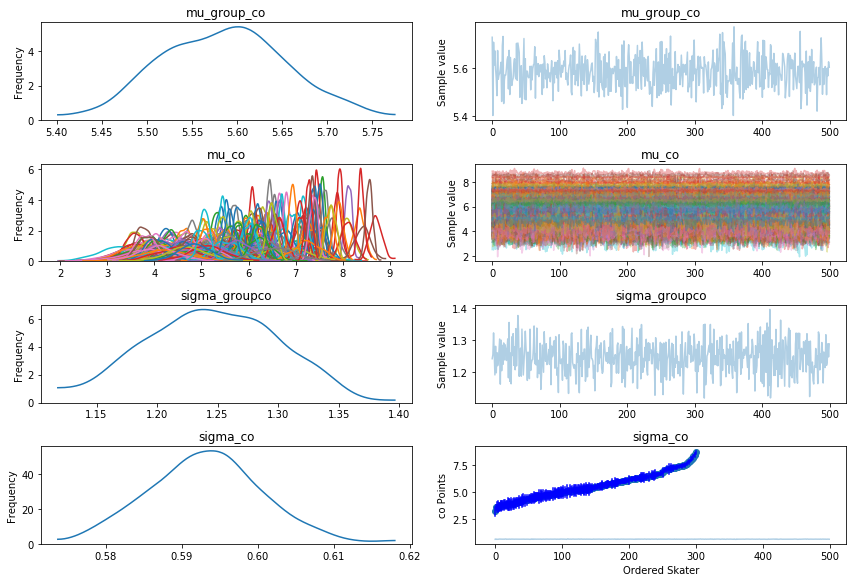

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:12<00:00, 80.62it/s]


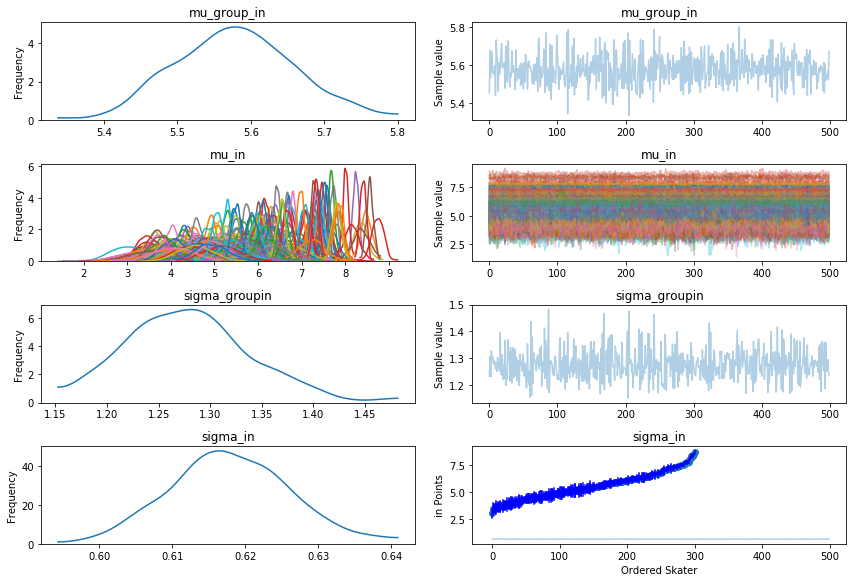

In [67]:
partial_pooling_traces = {}
partial_pooling_models = {}
partial_pooling_skater_shared = {}
for comp_type in COMP_TYPES:
    comps = components[components.comp_type == comp_type]
    skater = comps['skater_code'] = comps.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    partial_pooling_skater_shared[comp_type] = skater
    points = comps.points
    
    model = pm.Model()

    with model:
        mu_g = pm.Normal('mu_group_' + comp_type, 7.0, sd=1e5)
        sigma_g = pm.HalfCauchy('sigma_group' + comp_type, 5)
        
        mu = pm.Normal('mu_' + comp_type, mu=mu_g, sd=sigma_g, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + comp_type, 5)
        y = pm.Normal('y_' + comp_type, mu[skater], sd=sigma, observed=points)

    with model:
        trace = pm.sample()
    partial_pooling_traces[comp_type] = trace
    partial_pooling_models[comp_type] = model
    pm.traceplot(trace)

    estimates = pd.Series(trace['mu_' + comp_type].mean(axis=0), index=skaters)
    se = pd.Series(trace['mu_' + comp_type].std(axis=0), index=skaters)

    order = estimates.sort_values().index
    plt.scatter(range(len(estimates)), estimates[order])
    for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(comp_type + ' Points');plt.xlabel('Ordered Skater');
    plt.show()

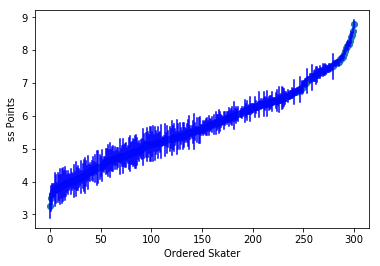

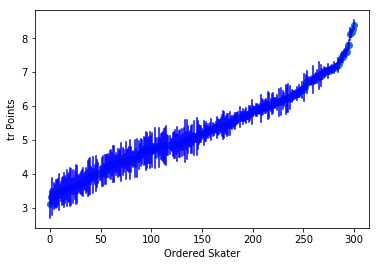

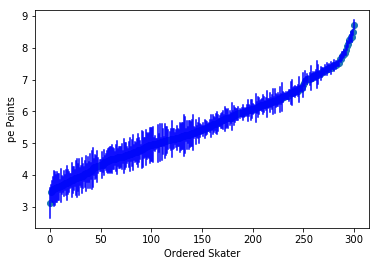

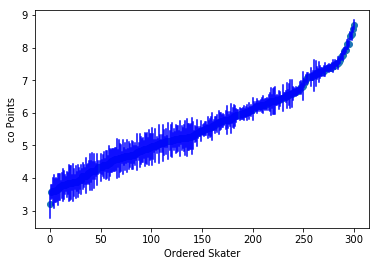

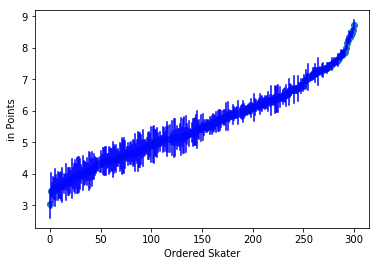

In [70]:
for comp_type in COMP_TYPES:
    plot_trace(partial_pooling_traces[comp_type], comp_type)
    plt.show()

In [69]:
# Make predictions.
ppc = {}
for comp_type in COMP_TYPES:
    with partial_pooling_models[comp_type] as m:
        partial_pooling_skater_shared[comp_type].set_value(
            np.asarray(components18[components18.comp_type == comp_type].skater_code))
        ppc[comp_type] = pm.sample_ppc(partial_pooling_traces[comp_type],
                                       model=m, samples=500)['y_' + comp_type]

100%|██████████| 500/500 [00:00<00:00, 1732.78it/s]


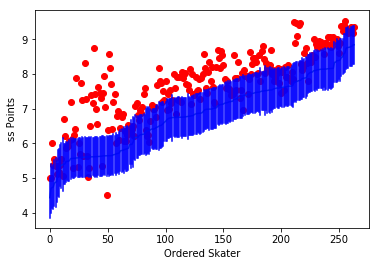

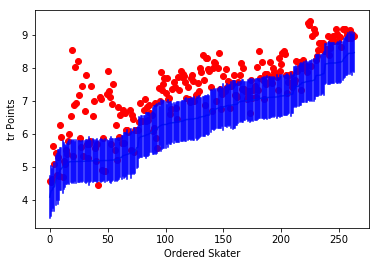

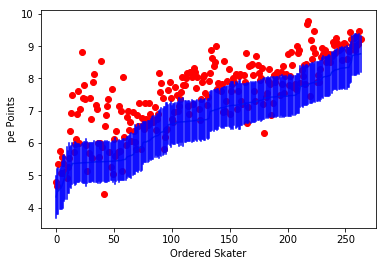

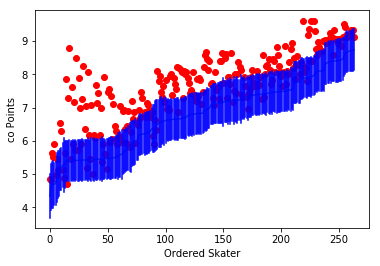

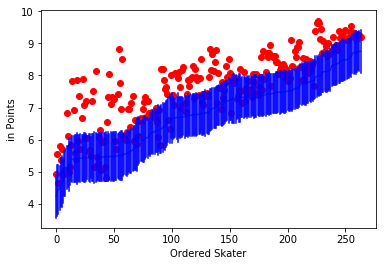

In [71]:
means = {}
for comp_type in COMP_TYPES:
    mean = ppc[comp_type].mean(axis=0)
    means[comp_type] = mean
    std = np.std(ppc[comp_type], axis=0)
    comp18type = components18[components18.comp_type == comp_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(comp18type.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(comp_type + ' Points');plt.xlabel('Ordered Skater');
    plt.show()

In [72]:
indices = {comp_type: 0 for comp_type in COMP_TYPES}
predictions_col = []
for index, row in components18.iterrows():
    predictions_col.append(means[row.comp_type][indices[row.comp_type]])
    indices[row.comp_type] += 1

In [76]:
components18.to_csv('fits/men_multi_comp_1.csv')